In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import random
# from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
import pickle

In [2]:
# Read in the data.
df = pd.read_csv('craigslist_car.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 16 columns):
post_time             3169 non-null object
price                 3003 non-null object
title                 3169 non-null object
VIN                   2099 non-null object
condition             1829 non-null object
cylinders             1709 non-null object
drive                 2341 non-null object
fuel                  3164 non-null object
odometer              2714 non-null float64
paint color           2326 non-null object
size                  913 non-null object
title status          3169 non-null object
transmission          3128 non-null object
type                  2496 non-null object
delivery available    0 non-null float64
cryptocurrency ok     0 non-null float64
dtypes: float64(3), object(13)
memory usage: 397.5+ KB


In [3]:
# Count the number of missing values in the dataset.
df.isnull().sum(axis = 0)

post_time               10
price                  176
title                   10
VIN                   1080
condition             1350
cylinders             1470
drive                  838
fuel                    15
odometer               465
paint color            853
size                  2266
title status            10
transmission            51
type                   683
delivery available    3179
cryptocurrency ok     3179
dtype: int64

In [4]:
# Price is our target variable, there are 176 missing values in price variable. I would drop them our here.
df.dropna(subset=['price'], inplace = True)

df.shape

(3003, 16)

In [5]:
#Because delivery available and cryptocurrency ok feaures are null value, drop them directly
#All used cars listed in craiglist have cleant title.
#VIN is the vehicle identification number, it doesn't have impact on price
df.drop(['delivery available','cryptocurrency ok','title status','VIN','post_time'],axis=1,inplace=True)

In [6]:
# Drop rows where all values are NA.
df.dropna(how = 'all', inplace=True)

# Drop columns where all values are NA.
df.dropna(axis = 1, how = 'all', inplace=True)

df.head()

,price,title,condition,cylinders,drive,fuel,odometer,paint color,size,transmission,type
0,$8499,2007 toyota prius,excellent,4 cylinders,fwd,gas,80409.0,white,compact,automatic,hatchback
1,$13950,2017 Nissan Altima,excellent,4 cylinders,fwd,gas,42028.0,black,full-size,automatic,sedan
2,$7995,2008 Toyota Yaris,NaN,NaN,NaN,gas,NaN,NaN,NaN,automatic,NaN
3,$34800,2017 lexus nx,NaN,NaN,NaN,other,NaN,NaN,NaN,other,NaN
4,$4995,1992 chevy c3500 crew cab,good,8 cylinders,rwd,gas,165000.0,red,full-size,automatic,pickup


### Split data into a training set and a test set, using 80 vs. 20 split

In [7]:
train_raw, test_raw = train_test_split(df, test_size = 0.2, random_state = 2020)

train_raw.shape, test_raw.shape

((2402, 11), (601, 11))

In [8]:
train_raw.reset_index(inplace=True)
test_raw.reset_index(inplace=True)

### Data preprocessing and feature engineering

In [9]:
class Transformer:
    def fit(self, X, y = None):
        pass
    
    def transform(self, X, y = None):
        df = pd.DataFrame()
        df['price'] = X.price.map(self.price_to_num)
        df['year'] = X.title.map(self.get_vehicle_year)
        df['maker'] = X.title.map(self.get_vehicle_maker)
        df = pd.concat([df, X.loc[:,'condition':'fuel']], axis = 1)
        df['cylinders'] = df.cylinders.map(self.cylinder_to_num)
        df['odometer'] = X.odometer.map(self.odometer_to_num)
        df = pd.concat([df, X.loc[:,'paint color':'type']], axis = 1)
        
        # Transform all string typed columns into lower cases.
        df = df.applymap(lambda x: x.lower() if type(x) == str else x)
        
        return df
        
    
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)
    
#####################################################################    

    def price_to_num(self, x):
        if type(x) == str:
            x = float(x.strip('$'))
        return x
    
    def get_vehicle_year(self, x):
        if type(x) == str:
            x = x.split()[0]
        return int(x)
    
    def get_vehicle_maker(self, x):
        if type(x) == str:
            s = x.split()
            x = s[1].lower()
            if x.isnumeric() and len(s) > 2:
                x = s[2].lower()
        return x
    
    def cylinder_to_num(self, x):
        if type(x) == str and x != 'other':
            x = int(x.split()[0])
        else:
            x = None
        return x
    
    
    def odometer_to_num(self, x):
        if type(x) == str:
            x = float(x)
        return x

In [10]:
# Example.
train_new = Transformer().fit_transform(train_raw)

train_new.head()

,price,year,maker,condition,cylinders,drive,fuel,odometer,paint color,size,transmission,type
0,19800.0,2000,ford,excellent,8.0,rwd,gas,75000.0,silver,full-size,automatic,truck
1,3990.0,2008,ford,NaN,NaN,NaN,gas,NaN,NaN,NaN,automatic,NaN
2,5400.0,2006,lexus,excellent,NaN,NaN,gas,190000.0,NaN,NaN,automatic,NaN
3,4995.0,2011,ford,good,6.0,fwd,gas,127767.0,NaN,mid-size,automatic,sedan
4,5000.0,2003,bmw,excellent,8.0,4wd,gas,114734.0,silver,full-size,automatic,suv


In [11]:
train_new['type'].unique()

array(['truck', nan, 'sedan', 'suv', 'convertible', 'hatchback', 'coupe',
       'pickup', 'other', 'van', 'wagon', 'offroad', 'mini-van', 'bus'],
      dtype=object)

In [19]:
train_new = train_new[train_new.price > 1].reset_index()
train_new.shape

(2392, 13)

In [20]:
class Encoder:
    '''
    This class will encode categorical vairables into appropriate forms.
    '''
    def fit(self, X, y = None):
        df = X.copy()
    
        # Get the frequency dict of car maker
        self.freq_maker = self.encode_maker_type(df.maker)
        # Get the frequency dict of car type
        self.freq_type = self.encode_maker_type(df.type)
    
    def transform(self, X, y = None):
        df = X.copy()
        
        # Get the indexes where fuel type is equal to 'electric'
        electric_idx = np.where(df.fuel == 'electric')[0]
        # Impute missing values in cylinders variable with 0 where the according fuel type is electric.
        df.cylinders.loc[electric_idx, ] = 0
        
        df.condition = df.condition.map(self.encode_condition)
        
        color_tmp = self.encode_color(df['paint color'])
        df = pd.concat([df, color_tmp], axis = 1)
        
        
        # Clean makers.
        correct_makers = {'impala':'chevrolet','mercedes':'mercedes-benz','mini':'mini-cooper','volkswagon':'volkswagen',
                  'alfa':'alfa-romeo','caddilac':'cadillac','mustang':'ford','kentworth':'kenworth','vw':'volkswagen',
                  'cadilac':'cadillac','savana':'gmc','chrystler':'chrysler','toyt':'toyota','jetta':'volkswagen',
                  'infinity':'infiniti','magnum':'dodge','volkwagen':'volkswagen','tahoe':'chevrolet',
                  'toyoya':'toyota','posche':'porsche','toyata':'toyota','chevelle':'chevrolet',
                  'camry':'toyota','f-350':'ford','535x':'bmw','gnc':'gmc','gto':'pontiac','528i':'bmw',
                  'sr5':'toyota','camero':'chevrolet','2007':'ford','corvette':'chevrolet',
                  'olds':'oldsmobile-cutlass','mighty':'mitsubishi','range':'land-rover','ve':'volvo',
                  'land':'land-rover','gt':'bmw'}
        df['maker'] = df.maker.replace(correct_makers)        

        
        # Add car maker frequency column to the dataframe
        df['maker'] = df.maker.map(lambda x: self.freq_maker.get(x, None))
        
         
        # Add car type frequency column to the dataframe
        df['type'] = df.type.map(lambda x: self.freq_type.get(x, None))
        
        df['size'] = df['size'].map(self.encode_size)
        
        dummy_drive = pd.get_dummies(df.drive, prefix='drive')
        dummy_fuel = pd.get_dummies(df.fuel, prefix='fuel')
        dummy_transmission = pd.get_dummies(df.transmission, prefix='transmission')
        df = pd.concat([df, dummy_drive, dummy_fuel, dummy_transmission], axis = 1)              
        
        # Drop the original columns.
        df.drop(['paint color', 'drive', 'fuel', 'transmission'], axis = 1, inplace = True)

        
        return df
    
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)
    
#########################################################################################

    def encode_condition(self, x):
        ords = {'salvage': 0, 'fair': 1, 'good': 2, 'like new': 3, 'new': 4, 'excellent': 5}
        if type(x) == str:
            x = ords[x]
        return x
    
    
    def encode_color(self, S):
        rgb = {'silver': [192, 192, 192], 'red': [255, 0, 0], 'black': [0, 0, 0], 'brown': [165, 42, 42], 'grey': [128, 128, 128], 
      'white': [255, 255, 255], 'blue': [0, 0, 255], 'green': [0, 128, 0], 'orange': [255, 165, 0], 'yellow': [255, 255, 0], 
      'purple': [128, 0, 128], 'custom': [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]}
        
        color_rgb = []
        for c in S:
            if type(c) == str:
                color_rgb.append(rgb[c])
            else:
                color_rgb.append([np.nan] * 3)

        color_df = pd.DataFrame(color_rgb, columns=['color_r', 'color_g', 'color_b'])
        return color_df    
     
    
    def encode_maker_type(self, X, y=None):
        '''
        Transform car maker into their frequency in the dataset.
        '''
        freq_dict = {}
        for item in X:
            if item in freq_dict:
                freq_dict[item] += 1
            else:
                freq_dict[item] = 1
        return freq_dict
    
    
    def encode_size(self, x):
        ords = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}
        if type(x) == str:
            x = ords[x]
        return x

In [21]:
p = Encoder()
train = p.fit_transform(train_new)

train.head(5)

,index,price,year,maker,condition,cylinders,odometer,size,type,color_r,...,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other
0,0,19800.0,2000,293.0,5.0,8.0,75000.0,4.0,91,192.0,...,0,1,0,0,1,0,0,1,0,0
1,1,3990.0,2008,293.0,NaN,NaN,NaN,NaN,518,NaN,...,0,0,0,0,1,0,0,1,0,0
2,2,5400.0,2006,99.0,5.0,NaN,190000.0,NaN,518,NaN,...,0,0,0,0,1,0,0,1,0,0
3,3,4995.0,2011,293.0,2.0,6.0,127767.0,3.0,644,NaN,...,1,0,0,0,1,0,0,1,0,0
4,4,5000.0,2003,113.0,5.0,8.0,114734.0,4.0,361,192.0,...,0,0,0,0,1,0,0,1,0,0


In [22]:
train.columns

Index(['index', 'price', 'year', 'maker', 'condition', 'cylinders', 'odometer',
       'size', 'type', 'color_r', 'color_g', 'color_b', 'drive_4wd',
       'drive_fwd', 'drive_rwd', 'fuel_diesel', 'fuel_electric', 'fuel_gas',
       'fuel_hybrid', 'fuel_other', 'transmission_automatic',
       'transmission_manual', 'transmission_other'],
      dtype='object')

In [23]:
train.drop(['index'], axis = 1, inplace = True)

In [24]:
with open('encoder.pkl', 'wb') as e:
    pickle.dump(p, e)

In [27]:
test_new = Transformer().fit_transform(test_raw)
test_new = test_new[test_new.price > 1].reset_index()
test = p.transform(test_new)
test.drop(['index'], axis = 1, inplace = True)
test.shape

(598, 22)

In [28]:
test.head()

,price,year,maker,condition,cylinders,odometer,size,type,color_r,color_g,...,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other
0,3498.0,2004,312.0,2.0,6.0,238939.0,3.0,644,192.0,192.0,...,1,0,0,0,1,0,0,1,0,0
1,34800.0,2014,81.0,2.0,8.0,7892.0,NaN,185,NaN,NaN,...,0,0,0,0,1,0,0,1,0,0
2,11995.0,2013,179.0,5.0,6.0,82785.0,2.0,127,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
3,21700.0,2016,46.0,NaN,NaN,50824.0,NaN,361,255.0,255.0,...,0,0,0,0,1,0,0,1,0,0
4,7500.0,2007,312.0,NaN,NaN,103095.0,NaN,518,NaN,NaN,...,0,0,0,0,1,0,0,1,0,0


In [29]:
test.columns

Index(['price', 'year', 'maker', 'condition', 'cylinders', 'odometer', 'size',
       'type', 'color_r', 'color_g', 'color_b', 'drive_4wd', 'drive_fwd',
       'drive_rwd', 'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid',
       'fuel_other', 'transmission_automatic', 'transmission_manual',
       'transmission_other'],
      dtype='object')

In [92]:
# Get the target variable and predictor variables from training set and test set respectively.
X_train_miss = train.drop('price', axis=1)
y_train = train.price.values

X_test_miss = test.drop('price', axis=1)
y_test = test.price.values

In [31]:
X_train_miss.shape, y_train.shape, X_test_miss.shape, y_test.shape

((2392, 21), (2392,), (598, 21), (598,))

### Missing data imputation

In [32]:
# Use IterativeImputer to impute the rest of missing values in the data.
imputer = IterativeImputer(n_nearest_features = 3, random_state = 2020)
imputer.fit(X_train_miss)

/Users/hercule/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=3, random_state=2020,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [33]:
X_train = imputer.transform(X_train_miss)
X_test = imputer.transform(X_test_miss)

In [34]:
X_train.shape, X_test.shape

((2392, 21), (598, 21))

### Build Random Forest Model

In [93]:
rf = RandomForestRegressor(random_state=2020)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=False)

In [94]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [95]:
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)), '\n')

print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MSE: 1.04e+07
train R2: 0.949 

test MSE: 4.65e+07
test R2: 0.707


### Optimization

In [96]:
trees = [50, 100, 300, 500, 1000,]
depths = [1, 2, 3, 4, 5]

rf_cv = GridSearchCV(rf, param_grid = {'max_depth': depths, 'n_estimators': trees}, 
                     scoring='neg_mean_squared_error')
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2020,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [97]:
rf_cv.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [98]:
rf_opt = RandomForestRegressor(n_estimators=rf_cv.best_params_['n_estimators'], 
                               max_depth=rf_cv.best_params_['max_depth'], 
                              random_state=2020)
rf_opt.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=False)

In [127]:
y_train_pred = rf_opt.predict(X_train)
y_test_pred = rf_opt.predict(X_test)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)), '\n')

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 5.10e+03
train R2: 0.671 

test MAE: 5.26e+03
test R2: 0.610


### Build GBDT

In [101]:
gbdt = GradientBoostingRegressor(random_state=2020)
gbdt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2020, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [128]:
y_train_pred = gbdt.predict(X_train)
y_test_pred = gbdt.predict(X_test)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)), '\n')

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 4.06e+03
train R2: 0.808 

test MAE: 4.55e+03
test R2: 0.671


### Optimization

In [103]:
trees = [50, 100, 300, 500, 1000,]
rates = [.01, .05, .1, .5, 1, 2]

gbdt_cv = GridSearchCV(gbdt, param_grid = {'learning_rate': rates, 'n_estimators': trees, 'max_depth': [1, 2, 3]}, 
                       scoring='neg_mean_squared_error')
gbdt_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [104]:
gbdt_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [105]:
gbdt_opt = GradientBoostingRegressor(learning_rate=gbdt_cv.best_params_['learning_rate'], 
                                    max_depth=gbdt_cv.best_params_['max_depth'], 
                                    n_estimators=gbdt_cv.best_params_['n_estimators'])
gbdt_opt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [129]:
y_train_pred = gbdt_opt.predict(X_train)
y_test_pred = gbdt_opt.predict(X_test)

print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)), '\n')

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 2.77e+03
train R2: 0.918 

test MAE: 4.32e+03
test R2: 0.675


In [130]:
feature_importance = gbdt_opt.feature_importances_
features = train.drop('price', axis = 1).columns

feature_importance_table = pd.DataFrame(feature_importance.reshape(21,1), index=features, columns=['importance']).\
sort_values(by = 'importance', ascending=True)
feature_importance_table

,importance
fuel_hybrid,0.000343
transmission_automatic,0.001187
drive_rwd,0.001537
fuel_gas,0.001853
fuel_electric,0.002397
transmission_manual,0.003657
fuel_other,0.003706
transmission_other,0.004639
drive_4wd,0.007253
color_r,0.009322


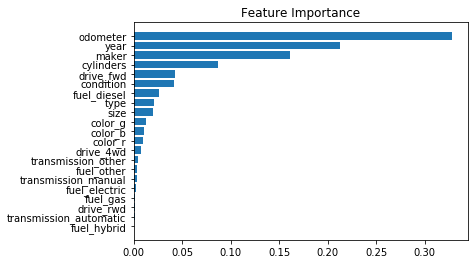

In [131]:
plt.barh(feature_importance_table.index, feature_importance_table.importance)
plt.title('Feature Importance')
plt.show()

### Build Xgboots model

In [111]:
from xgboost import XGBRegressor

In [112]:
# The performance of optimal hyperparameters picked by tuning is even worse than default ones,
# so I use the default values for all these hyperparameters.
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

[16:53:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [133]:
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

In [134]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)), '\n')

print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 4.16e+03
train R2: 0.793 

test MAE: 4.65e+03
test R2: 0.664


In [115]:
feature_importance = xgb.feature_importances_
features = train.drop('price', axis = 1).columns

<BarContainer object of 21 artists>

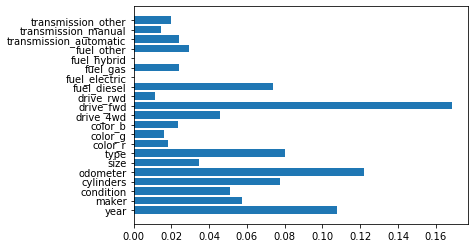

In [116]:
plt.barh(features, feature_importance)

In [117]:
with open('car_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

### Anomaly detection

In [118]:
# Combine the features and target into a complete matrix.
M_train = np.concatenate((y_train.reshape(-1, 1), X_train), axis = 1)
M_test = np.concatenate((y_test.reshape(-1, 1), X_test), axis = 1)

In [119]:
# training the isolation forest model
clf = IsolationForest(max_samples=100, max_features = 4, random_state=2020)
clf.fit(M_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=4, max_samples=100, n_estimators=100, n_jobs=None,
                random_state=2020, verbose=0, warm_start=False)

In [120]:
# predictions
y_pred_train = clf.predict(M_train)
y_pred_test = clf.predict(M_test)

In [121]:
np.mean(y_pred_train == -1)

0.3432274247491639

In [122]:
np.mean(y_pred_test == -1)

0.3311036789297659

In [123]:
M_train_df = pd.DataFrame(M_train, columns=train.columns)
M_test_df = pd.DataFrame(M_test, columns=test.columns)

In [124]:
M_train_df.loc[np.where(y_pred_train == -1)[0]]

,price,year,maker,condition,cylinders,odometer,size,type,color_r,color_g,...,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other
0,19800.0,2000.0,293.0,5.0,8.000000,75000.0,4.000000,91.0,192.000000,192.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5000.0,2003.0,113.0,5.0,8.000000,114734.0,4.000000,361.0,192.000000,192.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,30808.0,2018.0,78.0,5.0,4.000000,39960.0,2.000000,644.0,255.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,11300.0,2005.0,179.0,2.0,8.000000,162000.0,4.000000,91.0,128.000000,128.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
20,1500.0,1997.0,179.0,2.0,8.000000,286000.0,4.000000,91.0,255.000000,255.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,8800.0,2010.0,312.0,3.0,4.000000,100000.0,2.678899,518.0,140.316349,126.695436,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2379,4500.0,2007.0,312.0,2.0,4.000000,112000.0,3.000000,644.0,255.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2380,18888.0,2018.0,312.0,2.0,4.767808,40216.0,2.910067,644.0,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2383,24070.0,2018.0,179.0,5.0,4.000000,4000.0,2.678899,131.0,139.779233,131.216956,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [125]:
M_test_df.loc[np.where(y_pred_test == -1)[0]]

,price,year,maker,condition,cylinders,odometer,size,type,color_r,color_g,...,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_automatic,transmission_manual,transmission_other
2,11995.0,2013.0,179.0,5.0,6.000000,82785.000000,2.000000,127.0,0.000000,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,5500.0,1997.0,81.0,2.0,8.000000,185735.000000,4.000000,26.0,0.000000,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,2700.0,2005.0,39.0,5.0,6.000000,207000.000000,3.000000,361.0,192.000000,192.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12,331.0,2018.0,293.0,2.0,6.035161,2211.000000,3.291635,105.0,255.000000,255.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14,23995.0,2017.0,113.0,2.0,6.525059,35760.000000,3.331223,105.0,255.000000,255.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,60000.0,2009.0,1.0,5.0,12.000000,51500.000000,4.000000,127.0,192.000000,192.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
579,6.0,1988.0,2.0,2.0,4.000000,178054.445656,2.000000,361.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
581,4500.0,1989.0,81.0,2.0,8.000000,185913.966863,3.775291,91.0,139.965633,131.895096,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
582,4500.0,2002.0,30.0,5.0,8.000000,152000.000000,3.000000,127.0,255.000000,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
